---
title: "Solvers"
format:
  html:
    embed-resources: true
    code-fold: true
    toc: true
---

## Notes

From the root directory, run "pip install -e ." in your current environment to download the package with the environment in order to wrap around gym and rllib. The information of the download is in setup.py.

## Versions and Dependencies

In [1]:
import ray
print(ray.__version__)

2.39.0


In [2]:
import subprocess

# Run the pip list command and print the output
installed_packages = subprocess.run(["pip", "list"], capture_output=True, text=True)
print(installed_packages.stdout)

Package                   Version     Editable project location
------------------------- ----------- ---------------------------------
absl-py                   2.1.0
aiosignal                 1.3.2
appnope                   0.1.4
asttokens                 3.0.0
attrs                     25.1.0
certifi                   2025.1.31
charset-normalizer        3.4.1
click                     8.1.8
cloudpickle               3.1.1
cmake                     3.31.4
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
dm-tree                   0.1.9
exceptiongroup            1.2.2
executing                 2.1.0
Farama-Notifications      0.0.4
filelock                  3.17.0
fonttools                 4.56.0
frozenlist                1.5.0
fsspec                    2025.2.0
geosearch_package         0.1.0
gymnasium                 1.0.0
idna                      3.10
importlib_metadata  

## Libraries

In [3]:
import ray
from gymnasium.envs.registration import register
import gymnasium as gym
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.dqn import DQNConfig
import numpy as np
from ray import tune
from ray.rllib.algorithms.appo import APPOConfig
import matplotlib
import matplotlib.pyplot as plt
import torch
import pygame
from ray.rllib.models.torch.torch_action_dist import TorchCategorical
import os

In [4]:
# set up matplotlib interactive mode
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

In [5]:
from lunabot.geosearch import GeosearchEnv, Utils

## Load Environment

In [6]:
register(
    id="GeosearchEnv-v0",
    entry_point="geosearch_package.geosearch:GeosearchEnv",
)
env = GeosearchEnv()
#env = gym.make("GeosearchEnv-v0")
obs, info = env.reset()
print("Observation:", obs)

Observation: {'water_prob': array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
   

## Helper functions to visualize training

In [7]:
def plot_metrics(rewards, lengths):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Mean Rewards')
    ax1.set_xlabel('Evaluation Interval')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(rewards)

    ax2.set_title('Mean Episode Length')
    ax2.set_xlabel('Evaluation Interval')
    ax2.set_ylabel('Episode Length')
    ax2.plot(lengths)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [8]:
# Define a generic policy wrapper class that works with all RLlib algorithms
class RLlibPolicyWrapper:
    def __init__(self, algo):
        self.algo = algo
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def process_state(self, state):
        # Convert dictionary observation to array
        state_array = np.concatenate([
            state['height'],
            state['battery'],
            state['position'],
            state['sunlight'],
            state['dust'],
            state['water_prob'],
            state['gold_prob']
        ])
        return state_array
        
    def get_action(self, state):
        # Get action from policy
        action = self.algo.compute_single_action(
            observation=state,
            explore=False  # Don't use exploration during visualization
        )
        return action

def visualize_policy(env, algo, algo_name="Algorithm", episodes=5, max_steps=50, save_gif=True, gif_dir="policy_gifs"):
    """
    Generic function to visualize any RLlib algorithm's policy.
    
    Args:
        env: The environment instance
        algo: The RLlib algorithm instance (PPO, SAC, DQN, or APPO)
        algo_name: Name of the algorithm for the output filename
        episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        save_gif: Whether to save the visualization as a GIF
        gif_dir: Directory to save the GIFs (default: "policy_gifs")
    """
    try:
        # Initialize Pygame first
        pygame.init()
        
        # Create policy wrapper
        policy_wrapper = RLlibPolicyWrapper(algo)
        
        # Initialize visualization
        if env.render_mode != 'human':
            env.render_mode = 'human'
        env._init_render()
        
        frames = []
        total_reward = 0
        
        # Create directory for GIFs if it doesn't exist
        if save_gif:
            os.makedirs(gif_dir, exist_ok=True)
            gif_path = os.path.join(gif_dir, f"{algo_name.lower()}_policy.gif")
            print(f"GIF will be saved to: {gif_path}")
        
        for episode in range(episodes):
            state, info = env.reset()
            episode_reward = 0
            terminated = False
            steps = 0
            
            while not terminated and steps < max_steps:
                # Handle Pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        raise KeyboardInterrupt
                
                # Render current state
                env.render()
                if save_gif:
                    frame = pygame.surfarray.array3d(env.screen)
                    frames.append(np.transpose(frame, (1, 0, 2)))
                
                # Get action from policy
                action = policy_wrapper.get_action(state)
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                episode_reward += reward
                state = next_state
                steps += 1
                
                # Add small delay for visualization
                pygame.time.wait(66)  # ~15 FPS
                
            total_reward += episode_reward
            print(f"Episode {episode + 1} finished with reward: {episode_reward:.2f}")
        
        if save_gif and frames:
            Utils.create_gif(frames, filename=gif_path, duration=66)
            print(f"GIF saved successfully to {gif_path}")
        
        avg_reward = total_reward / episodes
        print(f"Average reward over {episodes} episodes: {avg_reward:.2f}")

    except KeyboardInterrupt:
        print("\nVisualization interrupted by user")
    
    except Exception as e:
        print(f"An error occurred during visualization: {str(e)}")
    
    finally:
        # Ensure proper cleanup
        if hasattr(env, 'close'):
            env.close()
        
        # Additional Pygame cleanup
        pygame.quit()
        print("Visualization completed and resources cleaned up")

## SAC

In [9]:
# ------------------------------------------
# Enhanced Custom Model with Recommendations
# ------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog

class AddCoordinates(nn.Module):
    """Add normalized coordinate channels to input grid"""
    def __init__(self, grid_size=20):
        super().__init__()
        xx, yy = torch.meshgrid(
            torch.linspace(-1, 1, grid_size),
            torch.linspace(-1, 1, grid_size),
            indexing='xy'  # Ensure consistent indexing
        )
        # Clone tensors to avoid shared memory
        self.register_buffer('xx', xx.clone())
        self.register_buffer('yy', yy.clone())
        
    def forward(self, x):
        batch_size = x.shape[0]
        coords = torch.stack([self.xx, self.yy], dim=0)
        coords = coords.unsqueeze(0).expand(batch_size, -1, -1, -1)
        return torch.cat([x, coords], dim=1)

class SpatialAttention(nn.Module):
    """Attention over spatial features"""
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H*W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H*W)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)
        value = self.value(x).view(batch_size, -1, H*W)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)
        return self.gamma*out + x

class EnhancedGeosearchModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        self.grid_size = 20

        # ========== Spatial Processing Branch ==========
        self.coord_adder = AddCoordinates(self.grid_size)
        self.conv_net = nn.Sequential(
            nn.Conv2d(4, 32, 5, padding=2),  # 4 channels: water_prob + coords
            nn.BatchNorm2d(32),
            SpatialAttention(32),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SpatialAttention(64),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SpatialAttention(128),
            
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # ========== Non-Spatial Processing Branch ==========
        # Height processing
        self.height_net = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        
        # Other features processing
        self.feature_net = nn.Sequential(
            nn.Linear(4, 64),  # battery, sunlight, dust, depleted
            nn.LayerNorm(64),
            nn.ReLU()
        )

        # ========== Cross-Modal Fusion ==========
        self.fusion = nn.Sequential(
            nn.Linear(2048 + 32 + 64, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU()
        )

        # ========== Output Heads ==========
        self.policy_head = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )
        
        self.value_head = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.aux_head = nn.Linear(256, 1)

        # ========== Normalization ==========
        self.register_buffer('water_mean', torch.tensor([0.3, 0.0]))
        self.register_buffer('water_std', torch.tensor([0.15, 1.0]))


    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"]

        # Check if the observation is a dict or a flattened tensor.
        if isinstance(obs, dict):
            # Expect keys: water_prob, battery, sunlight, dust, local_heights, location_depleted
            water_prob = obs["water_prob"]
            battery = obs["battery"]
            sunlight = obs["sunlight"]
            dust = obs["dust"]
            local_heights = obs["local_heights"]
            location_depleted = obs["location_depleted"]
            # Ensure water_prob is 4D: [B, 2, 20, 20]
            water_prob = water_prob.view(-1, 2, 20, 20)
        else:
            # Otherwise, assume a flat observation of length 809:
            # 800 for water_prob (2*20*20), then battery (1), sunlight (1),
            # dust (1), local_heights (5), location_depleted (1)
            water_prob = obs[:, :800].view(-1, 2, 20, 20)
            battery = obs[:, 800:801]
            sunlight = obs[:, 801:802]
            dust = obs[:, 802:803]
            local_heights = obs[:, 803:808]
            location_depleted = obs[:, 808:809]

        # ========== Input Normalization ==========
        # Reshape water_mean and water_std to broadcast properly.
        water_map = (water_prob - self.water_mean.view(1, 2, 1, 1)) / self.water_std.view(1, 2, 1, 1)

        # Process non-spatial features ensuring they are 2D (batch_size, feature_dim)
        non_spatial = torch.cat([
            battery.view(-1, 1),
            sunlight.view(-1, 1),
            dust.view(-1, 1),
            location_depleted.view(-1, 1)
        ], dim=-1)

        # ========== Spatial Processing ==========
        spatial_feat = self.coord_adder(water_map)
        spatial_feat = self.conv_net(spatial_feat)
        spatial_feat = spatial_feat.flatten(start_dim=1)  # Shape: [B, features]

        # ========== Non-Spatial Processing ==========
        # Process local heights: reshape to [B, 1, 5] for Conv1d
        heights = local_heights.unsqueeze(1)
        height_feat = self.height_net(heights)       # Shape: [B, 32]
        feature_feat = self.feature_net(non_spatial)   # Shape: [B, 64]

        # ========== Fusion ==========
        fused = torch.cat([spatial_feat, height_feat, feature_feat], dim=-1)
        fused = self.fusion(fused)

        # ========== Outputs ==========
        logits = self.policy_head(fused)
        self._value_out = self.value_head(fused)

        return logits, state

    def value_function(self):
        return self._value_out.squeeze(-1)

    def forward_train(self, input_dict, state, seq_lens):
        logits, state_out = self.forward(input_dict, state, seq_lens)
        
        # Auxiliary task: Water presence prediction
        if "water_label" in input_dict:
            aux_out = self.aux_head(self.fusion_out)
            aux_loss = F.binary_cross_entropy_with_logits(
                aux_out, input_dict["water_label"].float())
            self._aux_loss = aux_loss
        else:
            self._aux_loss = 0.0
            
        return logits, state_out

    def loss(self, model_out, dist_class, train_batch):
        base_loss = super().loss(model_out, dist_class, train_batch)
        return base_loss + 0.2 * self._aux_loss

# Register the model
ModelCatalog.register_custom_model("geo_model", EnhancedGeosearchModel)

### Ray Instance

In [10]:
from ray.rllib.algorithms.sac import SACConfig
import numpy as np

# ------------------------------------------
# SAC Configuration and Algorithm Build
# ------------------------------------------
from ray.rllib.algorithms.sac import SACConfig

config = SACConfig()
config.framework_str = "torch"
config.env = GeosearchEnv

# IMPORTANT: Disable RLlib's preprocessor so that dict observations are preserved.
config.model = {
    "_disable_preprocessor_api": True,
    "max_seq_len": 20
}


config.training(
    policy_model_config={
        "custom_model": "geo_model",
        "custom_action_dist": "categorical",
    },
    q_model_config={
        "custom_model": "geo_model",
        "custom_action_dist": "categorical",
    },
    lr=3e-4,
    tau=0.005,
    initial_alpha=0.2,
    target_entropy="auto",
    train_batch_size=512,
    replay_buffer_config={
        "type": "ReplayBuffer",
        "capacity": 500000,
        "alpha": 0.6,
        "beta": 0.4
    }
)

config.rollout_fragment_length = 200
config.num_workers = 8
config.evaluation_num_workers = 4
config.evaluation_interval = 50
config.evaluation_duration = 30

# config.gamma = 0.99
# config.exploration_config = {
#     "type": "EpsilonGreedy",
#     "initial_epsilon": 1.0,
#     "final_epsilon": 0.05,
#     "epsilon_timesteps": 300000,
# }

config.api_stack(
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False
)

algo = config.build()

2025-02-14 16:35:59,004	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interfa

(RolloutWorker pid=83731) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Training

In [11]:
rewards = []
lengths = []

KeyboardInterrupt: 

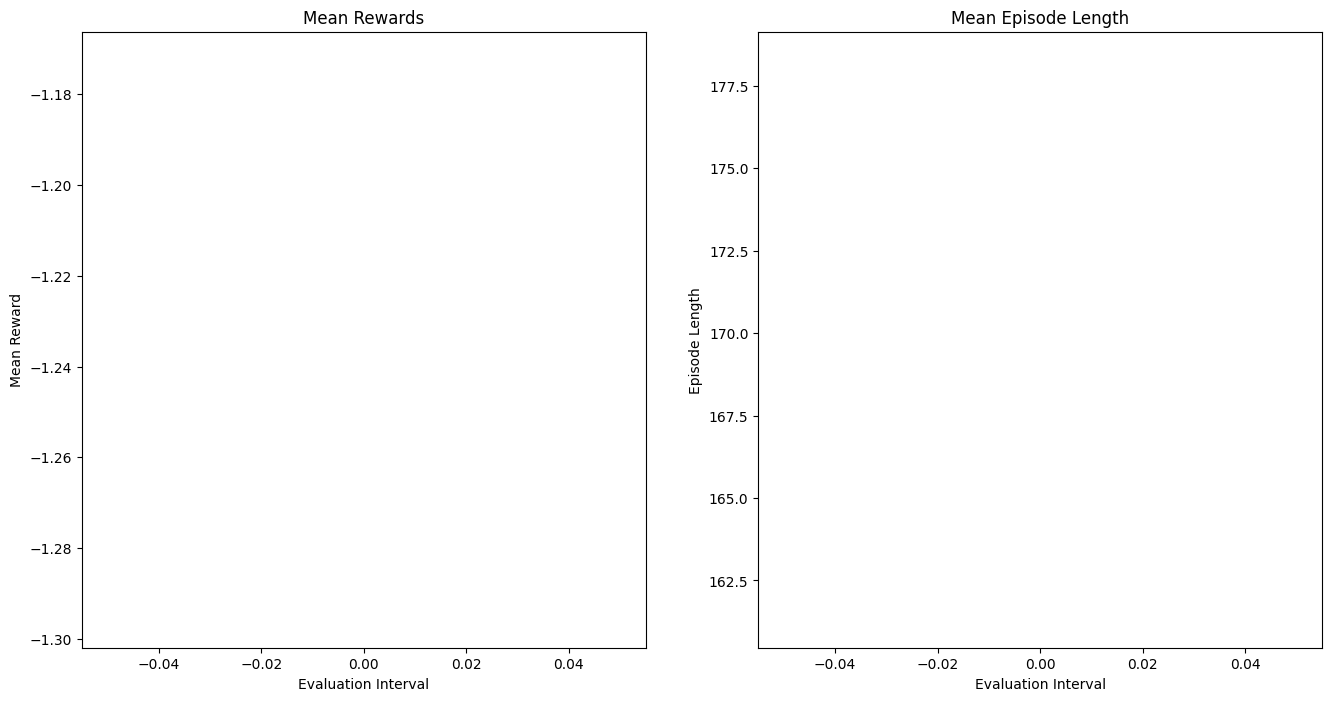

In [12]:
import time

TRAINING_ITERATIONS = 9000
EVAL_INTERVAL = 50


# Modified training loop with better tracking
best_reward = float('-inf')
start_time = time.time()

for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        current_reward = evaluation_results['env_runners']['episode_return_mean']
        rewards.append(current_reward)
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        
        # Save best model
        if current_reward > best_reward:
            best_reward = current_reward
            checkpoint_dir_sac = f"checkpoints/sac_best_reward"
            algo.save(checkpoint_dir_sac)
            
        # Print progress
        elapsed_time = (time.time() - start_time) / 3600  # in hours
        print(f"\nIteration {i+1}/{TRAINING_ITERATIONS}")
        print(f"Time elapsed: {elapsed_time:.2f} hours")
        print(f"Current reward: {current_reward:.2f}")
        print(f"Best reward so far: {best_reward:.2f}")
        
        plot_metrics(rewards, lengths)

### Save the weights:

In [ ]:
#policy = algo.get_policy()
# weights = algo.get_weights()

NameError: name '__file__' is not defined

### Visualize how the algorithm performs:

In [ ]:
# For SAC
# For SAC: Ensure you load the best model
algo.restore(checkpoint_dir_sac)

env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="sac_last", episodes=3, max_steps=365)

NameError: name 'algo' is not defined